# Parallel Julia Set

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiML/blob/main/docs/Cached_Parallel_Example.ipynb)
&nbsp; • &nbsp; [🌐 **Φ<sub>ML</sub>**](https://github.com/tum-pbs/PhiML)
&nbsp; • &nbsp; [📖 **Documentation**](https://tum-pbs.github.io/PhiML/)
&nbsp; • &nbsp; [🔗 **API**](https://tum-pbs.github.io/PhiML/phiml)
&nbsp; • &nbsp; [**▶ Videos**]()
&nbsp; • &nbsp; [<img src="images/colab_logo_small.png" height=4>](https://colab.research.google.com/github/tum-pbs/PhiML/blob/main/docs/Examples.ipynb) [**Examples**](https://tum-pbs.github.io/PhiML/Examples.html)

This is an example of using Φ<sub>ML</sub>'s parallel computation capabilities to compute the Julia set. We will also explore disk caching to limit memory usage.

This notebook assumes you are familiar with parallel computation in Φ<sub>ML</sub> as explained in the [Parallel Computation in Φ<sub>ML</sub>](Parallel_Compute.html) tutorial.

In [ ]:
%%capture
!pip install phiml

## Defining the Julia Set

The following cell implements the [Julia set](https://en.wikipedia.org/wiki/Julia_set) computation. The `JuliaSet` dataclass takes a complex constant `c` and start point `z0`, both of which can be a set of complex numbers. The `values` property represents the computation to be parallelized.

In [1]:
from dataclasses import dataclass
from functools import cached_property
from phiml import Tensor, iterate

def belongs_to_julia_set(z, c, iter_count: int):
    return iterate(lambda z, k: (z ** 2 + c, k + (abs(z) < 2)), iter_count, z, 0)[1]

@dataclass
class JuliaSet:
    c: Tensor
    z0: Tensor
    iter_count: int = 50

    @cached_property
    def values(self):
        return belongs_to_julia_set(self.z0, self.c, self.iter_count)

## Parallel Computation

Now let's compute the Julia set for a range of parameters. We will parallelize over the `time` dim of `c`, which represents different Julia sets.

(timeᵇ=64, reˢ=512, imˢ=512) int64 5.257 ± 9.516 (0e+00...5e+01)


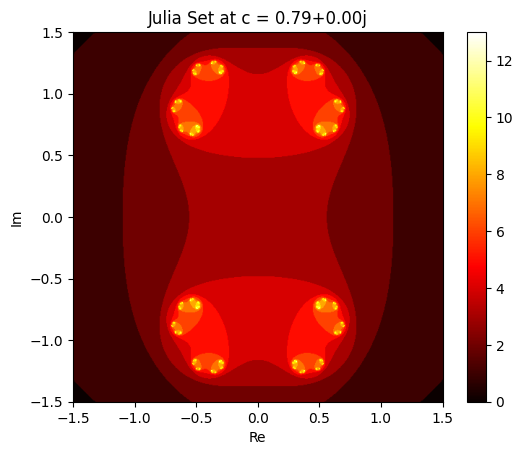

In [2]:
from julia_set import JuliaSet  # identical to above cell, but can be imported by workers
from phiml.math import PI, exp, linspace, batch, spatial
from phiml.dataclasses import parallel_compute

if __name__ == "__main__":
    c = 0.7885 * exp(1j * linspace(0, 2 * PI, batch(time=64)))
    z0_re = linspace(-1.5, 1.5, spatial(re=512))
    z0_im = linspace(-1.5, 1.5, spatial(im=512))
    z0 = z0_re + 1j * z0_im
    julia = JuliaSet(c, z0)
    parallel_compute(julia, [JuliaSet.values], 'time')
    print(julia.values)

    import matplotlib.pyplot as plt
    plt.imshow(julia.values.time[0].numpy('im,re'), extent=(-1.5, 1.5, -1.5, 1.5), cmap='hot')
    plt.colorbar()
    plt.title(f"Julia Set at c = {complex(julia.c.time[0]):.2f}")
    plt.xlabel('Re')
    plt.ylabel('Im')
    plt.show()


## Disk Caching

Note that the full output `julia.values` is quite large, as it contains 64 different Julia sets at a resolution of 512x512 each. We can use Φ<sub>ML</sub>'s disk caching to avoid keeping all of this data in memory at once.

In [3]:
if __name__ == "__main__":
    julia = JuliaSet(c, z0)
    parallel_compute(julia, [JuliaSet.values], 'time', cache_dir="cache", memory_limit=1024)
    print(julia.values)

(timeᵇ=64, reˢ=512, imˢ=512) int64 stacked numpy dense ref/tracer


Note that printing `julia.values` now shows that the data is cached on disk. You can explore the `cache` directory to see the cached files.
Let's print all cache files referenced by `julia.values`:

In [4]:
from phiml.dataclasses import get_cache_files
str(get_cache_files(julia.values))[:100]

"{'cache\\\\s0_i10_3.h5', 'cache\\\\s0_i19_3.h5', 'cache\\\\s0_i17_3.h5', 'cache\\\\s0_i56_3.h5', 'cache\\\\s0_"

While `julia.values` behaves just like any other Φ<sub>ML</sub> tensor, it is now backed by various HDF5 files on disk, each created by one of the workers employed by `parallel_compute`.

The data is loaded from disk on demand, so you can still access individual Julia sets without loading everything into memory at once. Let's visualize again, but register when data is loaded from disk:

In [5]:
from phiml.dataclasses import on_load_into_memory
on_load_into_memory(lambda t: print(f"Loading data {t.shape} from {t.source}"))
julia.values.time[0]

(reˢ=512, imˢ=512) int64 numpy dense ref/tracer

In [6]:
julia.values.time[0].mean

Loading data (reˢ=512, imˢ=512) from cache\s0_i0_3.h5


np.float64(2.4266815185546875)

Loading data (reˢ=512, imˢ=512) from cache\s0_i32_3.h5


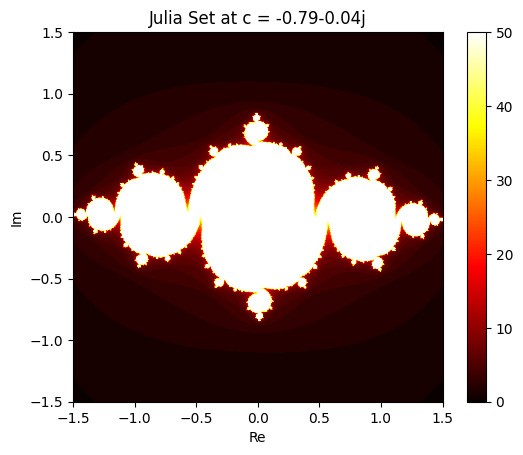

In [7]:
import matplotlib.pyplot as plt
plt.imshow(julia.values.time[32].numpy('im,re'), extent=(-1.5, 1.5, -1.5, 1.5), cmap='hot')
plt.colorbar()
plt.title(f"Julia Set at c = {complex(julia.c.time[32]):.2f}")
plt.xlabel('Re')
plt.ylabel('Im')
plt.show()

We can configure the cache behavior further, e.g., setting the time a tensor is kept in memory before being evicted again:

In [8]:
from phiml.dataclasses import set_cache_ttl
set_cache_ttl(5.0)  # seconds
print(julia.values.time[5].mean)
print(julia.values.time[5].mean)

Cache files are not deleted automatically. You must delete them manually when they are no longer needed. When re-running the code, the existing cache files will not be overwritten. Instead, new cache files with incremented indices will be created.

If your host process is using the GPU for the main workflow, you may want worker threads to use the CPU only. You can configure this using `load_cache_as`:

In [13]:
from phiml.dataclasses import load_cache_as
load_cache_as('torch', worker_backend='numpy');

This way you can deal with PyTorch tensors on the host process, while workers will use NumPy arrays. The result is converted back to a PyTorch tensor when loaded into memory on the host process.